# Equalizer Comparison
This example uses discrete-channel model

In [1]:
#------------------------------------------------------------------------------#
# Adding comm module path
#------------------------------------------------------------------------------#
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#------------------------------------------------------------------------------#
# Import Libraries
#------------------------------------------------------------------------------#
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline 

pi = np.pi
from numpy import exp as exp
from numpy import log as log
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import sign as sign
from numpy import real as real
from numpy import imag as imag

from scipy import signal
from scipy.signal import convolve
from scipy.signal import lfilter
from scipy.linalg import toeplitz

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Activation
from keras.layers import Embedding

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from utils.utils_filter import *
from utils.utils_waveform import *
from utils.utils_report import *
from utils.utils_matrix import *

from adaptive_filters.lms import *
from adaptive_filters.rls import *

from equalizers.linear import *

from modulation.bpsk_modulator import BpskModulator
from modulation.bpsk_demodulator import BpskDemodulator

## Generating Dataset

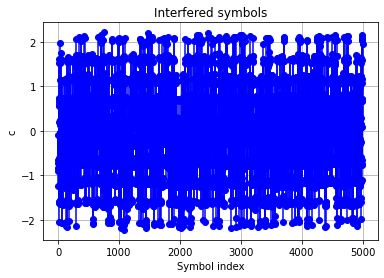

In [3]:
#------------------------------------------------------------------------------#
# Data Parameters
#------------------------------------------------------------------------------#
N = 5000 # Number of bits to generate
bits = np.random.normal(0, 1, N) > 0

modulator = BpskModulator()
demodulator = BpskDemodulator()

symbols = modulator(bits)

#------------------------------------------------------------------------------#
# Channel Parameters
#------------------------------------------------------------------------------#
c = np.array([0.90, -0.15, 0.20, 0.10, -0.05]) # G. Stüber's example 7.2 in Section 7, Principles of Mobile Communication
#c = np.array([0.2835, 0.2031, 0.1455, 0.1043, 0.0747, 0.0535, 0.0384, 0.0275, 0.0197, 0.0141, 0.0101, 0.0072, 0.0052, 0.0037, 0.0027, 0.0019])
#c = np.array([0.1, 0.90, -0.15, 0.20, 0.01, -0.05]) # Some terrible channel
#c = np.array([0.407, 0.815, 0.407]) # Channel B
c = np.array([0.227, 0.460, 0.688, 0.460, 0.227]) # Channel C
snr_db = 25
snr = 10**(snr_db/10)

#------------------------------------------------------------------------------#
# Received signal
#------------------------------------------------------------------------------#
# TODO: Check SNR
symbolsIsi = lfilter(c, 1, symbols)
s_p = power(symbols) # Signal power
n_p = s_p/snr # Noise power
noise = sqrt(n_p) * np.random.normal(0, 1, symbolsIsi.size)
symbolsIsi = symbolsIsi.astype(float) + noise

# Plotting
plt.figure()
plt.title('Interfered symbols')
plt.stem(symbolsIsi, basefmt=" ", linefmt="blue", markerfmt="bo")
plt.grid()
plt.xlabel('Symbol index')
plt.ylabel('c')
plt.show()

## Linear Equalizers

In [4]:
print("No Equalizer")
linkReport(symbolsIsi, symbols, demodulator)

No Equalizer
Link Report (BPSK):
    SER, 4.408e-1, (2204/5000)
    BER, 4.408e-1, (2204/5000)
    EVM, 124.29042804869484 [RMS]


### Zero-Forcing

In [5]:
# Get filter taps
wZf = zeroForcing(c)

# Record and equalize for each weight to monitor EVM
yZf = filterB(wZf, symbolsIsi)

print("ZF Equalizer")
linkReport(yZf, symbols, demodulator)

ZF Equalizer
Link Report (BPSK):
    SER, 4.5520000000000005e-1, (2276/5000)
    BER, 4.5520000000000005e-1, (2276/5000)
    EVM, 1071.3536934495178 [RMS]


### MMSE

In [6]:
# TODO: filter delay zf ve mmse
print("TODO Remains")
# Get filter taps
wMmse = minimumMeanSquareError(c, n_p)

# Record and equalize for each weight to monitor EVM
yMmse = filterB(wMmse, symbolsIsi, wMmse.shape[0]-2)

print("MMSE Equalizer")
linkReport(yMmse, symbols, demodulator)

TODO Remains
MMSE Equalizer
Link Report (BPSK):
    SER, 5.6000000000000005e-2, (280/5000)
    BER, 5.6000000000000005e-2, (280/5000)
    EVM, 53.14381894977538 [RMS]


## Adaptive Linear Equalizers
Note: Training dataset can be chosen with different offset which corresponds delay. It changes EVM.

In [7]:
# Parameters
Ne = c.size # Filter taps, It could be less

# LMS parameter
muLms = 0.1 # Convergence rate

# NLMS parameter
muNlms = 0.2 # Convergence rage

lmbdaRls = 0.999 # Forgetting factor
deltaRls = 0.1 # Regularization term 

### LMS Algorithm

LMS Equalizer
Link Report (BPSK):
    SER, 3.166e-1, (1583/5000)
    BER, 3.166e-1, (1583/5000)
    EVM, 92.17086759018345 [RMS]


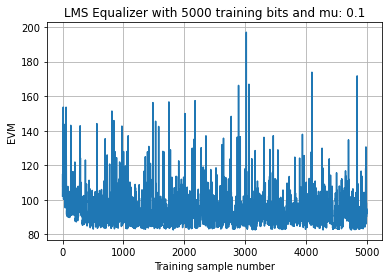

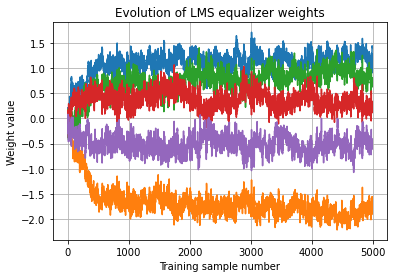

In [8]:
lms = Lms(Ne, muLms)

# Memory allocation to record evolution of adaptive filter
wRecLms = np.zeros((Ne, N-Ne))
evmLms = np.zeros(N-Ne)

# Using the training data to estimate the equalizer weights
for k in range(Ne,N):
    xk = symbolsIsi[(k-Ne):(k)]
    w, e = lms.evalChunk(xk, symbols[k-1])    
    
    # Record and equalize for each weight to monitor EVM
    y = filterB(w, symbolsIsi)
    wRecLms[:, k-Ne] = w.flatten()
    evmLms[k-Ne] = errorVectorMagnitude(y, symbols)

print("LMS Equalizer")
linkReport(y, symbols, demodulator)

# Plot EVM change
plt.figure()
plt.plot(evmLms)
plt.grid()
plt.title('LMS Equalizer with ' + str(N) + ' training bits and mu: ' + str(muLms))
plt.xlabel('Training sample number')
plt.ylabel('EVM')

# Plot filter taps
plt.figure()
plt.plot(wRecLms.T)
plt.grid()
plt.title('Evolution of LMS equalizer weights')
plt.xlabel('Training sample number')
plt.ylabel('Weight value')
plt.show()

### NLMS Algorithm

NLMS Equalizer
Link Report (BPSK):
    SER, 2.8720000000000003e-1, (1436/5000)
    BER, 2.8720000000000003e-1, (1436/5000)
    EVM, 85.41026133676743 [RMS]


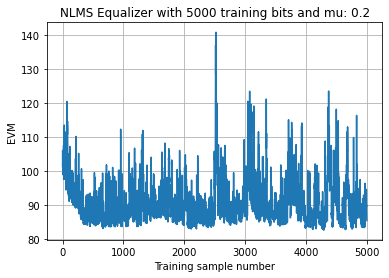

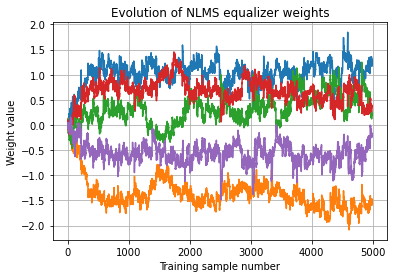

In [9]:
nlms = Lms(Ne, muNlms, "nlms")

# Memory allocation to record evolution of adaptive filter
wRecNlms = np.zeros((Ne, N-Ne))
evmNlms = np.zeros(N-Ne)

# Using the training data to estimate the equalizer weights
for k in range(Ne,N):
    xk = symbolsIsi[(k-Ne):(k)]
    w, e = nlms.evalChunk(xk, symbols[k-1])    
    
    # Record and equalize for each weight to monitor EVM
    y = filterB(w, symbolsIsi)
    wRecNlms[:, k-Ne] = w.flatten()
    evmNlms[k-Ne] = errorVectorMagnitude(y, symbols)

print("NLMS Equalizer")
linkReport(y, symbols, demodulator)

# Plot EVM change
plt.figure()
plt.plot(evmNlms)
plt.grid()
plt.title('NLMS Equalizer with ' + str(N) + ' training bits and mu: ' + str(muNlms))
plt.xlabel('Training sample number')
plt.ylabel('EVM')

# Plot filter taps
plt.figure()
plt.plot(wRecNlms.T)
plt.grid()
plt.title('Evolution of NLMS equalizer weights')
plt.xlabel('Training sample number')
plt.ylabel('Weight value')
plt.show()

### RLS Algorithm

RLS Equalizer
Link Report (BPSK):
    SER, 2.572e-1, (1286/5000)
    BER, 2.572e-1, (1286/5000)
    EVM, 82.46041859042134 [RMS]


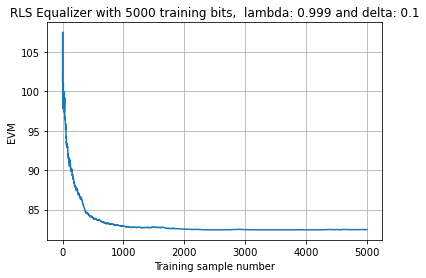

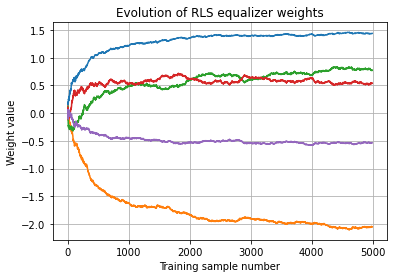

In [10]:
rls = Rls(Ne, lmbdaRls, deltaRls)

# Memory allocation to record evolution of adaptive filter
wRecRls = np.zeros((Ne, N-Ne))
evmRls = np.zeros(N-Ne)

# Using the training data to estimate the equalizer weights
for k in range(Ne,N):
    xk = symbolsIsi[(k-Ne):(k)]
    w, e = rls.evalChunk(xk, symbols[k-1])    
    
    # Record and equalize for each weight to monitor EVM
    y = filterB(w, symbolsIsi)
    wRecRls[:, k-Ne] = w.flatten()
    evmRls[k-Ne] = errorVectorMagnitude(y, symbols)

print("RLS Equalizer")
linkReport(y, symbols, demodulator)

# Plot EVM change
plt.figure()
plt.plot(evmRls)
plt.grid()
plt.title('RLS Equalizer with ' + str(N) + ' training bits,  lambda: ' + str(lmbdaRls) + ' and delta: ' + str(deltaRls))
plt.xlabel('Training sample number')
plt.ylabel('EVM')

# Plot filter taps
plt.figure()
plt.plot(wRecRls.T)
plt.grid()
plt.title('Evolution of RLS equalizer weights')
plt.xlabel('Training sample number')
plt.ylabel('Weight value')
plt.show()

## Machine Learning Methods

### Common Dataset Operations

In [11]:
cLen = c.size
labeledNum = N-cLen
trainNum = 1000
testNum = labeledNum - trainNum

# Allocate mems
xSet = np.zeros((labeledNum, cLen))
ySet = np.zeros(labeledNum)

# Get x and y set
for k in range(cLen,N):
    xSet[k-cLen, :] = xk = symbolsIsi[(k-cLen):(k)]
    ySet[k-cLen] = symbols[k-1]   

# Get train and test data
xTrain = xSet[0:trainNum, :]
xTest = xSet[trainNum::, :]
 
yTrain = ySet[0:trainNum]
yTest = ySet[trainNum::]

# Get 3D versions
XTrain = convert3DTensor(xTrain)
XTest = convert3DTensor(xTest)

YTrain = convert3DTensor(yTrain)
YTest = convert3DTensor(yTest)


In [12]:
## Creating pandas dataframe from numpy array
#dataset = pd.DataFrame(xSet)
#dataset['Y'] = ySet
#dataset.head()
#xTrain, xTest, yTrain, yTest = train_test_split(dataset.iloc[:,:cLen], dataset['Y'], test_size=0.33,  random_state=42)

### Random Forest Classifier

This is not an appropriate equalizer solution . It is here because of curiosity

In [13]:
# Random Forest Classifier
mdlRFC = RandomForestClassifier()

historyRFC = mdlRFC.fit(xTrain, yTrain)

# Predict from model
yPredRFC = mdlRFC.predict(xTest)

# Results
linkReport(yPredRFC, yTest, demodulator)
print("\nClassification Report:")
print(classification_report(yTest, yPredRFC))

Link Report (BPSK):
    SER, 1.551939924906133e-1, (620/3995)
    BER, 1.551939924906133e-1, (620/3995)
    EVM, 78.78933747420731 [RMS]

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.85      0.83      0.84      1985
         1.0       0.84      0.86      0.85      2010

    accuracy                           0.84      3995
   macro avg       0.84      0.84      0.84      3995
weighted avg       0.84      0.84      0.84      3995



### LSTM


SUMMARY:
Model: "LSTM_EQUALIZER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


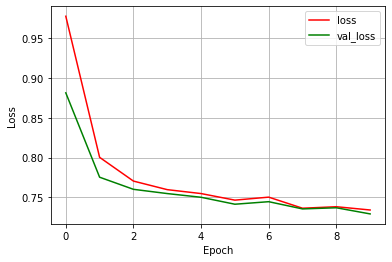

Link Report (BPSK):
    SER, 3.5744680851063833e-1, (1428/3995)
    BER, 3.5744680851063833e-1, (1428/3995)
    EVM, 116.58445389447097 [RMS]


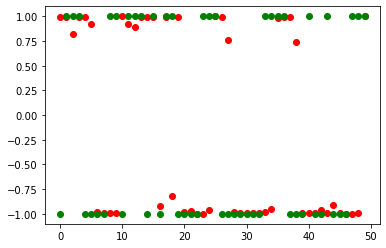

In [14]:
# LSTM
mdlLSTM = Sequential(name="LSTM_EQUALIZER")

mdlLSTM.add(LSTM(1,
            activation="tanh",
            recurrent_activation="tanh",
            input_shape=(cLen, 1),
            #batch_input_shape=(None, cLen, 1), 
            return_sequences=False))

lossLSTM = keras.losses.MeanAbsoluteError()
optLSTM = keras.optimizers.Adam(learning_rate=0.1)

mdlLSTM.compile(loss=lossLSTM,
                optimizer=optLSTM,
                metrics=['accuracy'],
                )

print("\nSUMMARY:")
mdlLSTM.summary()

historyLstm = mdlLSTM.fit(XTrain, YTrain, 
                          epochs=10,
                          validation_data=(XTest, YTest),
                          verbose=0,
                          )
# Plot loss
plt.plot(historyLstm.history['loss'], c='r')
plt.plot(historyLstm.history['val_loss'], c='g')
plt.grid()
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predict
yPredLSTM = mdlLSTM.predict(XTest)
linkReport(yPredLSTM, yTest, demodulator)

# Plot 
len = 50 #_y_test.shape[0]
plt.scatter(range(len), yPredLSTM[0:len].reshape(len), c='r')
plt.scatter(range(len), YTest[0:len].reshape(len), c='g')

### BiLSTM
TODO: birşeyler yanlış


SUMMARY:
Model: "BiLSTM_EQUALIZER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 2)                24        
 l)                                                              
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


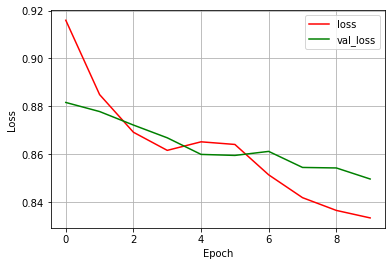

Link Report (BPSK):
    SER, 3.6045056320400497e-1, (1440/3995)
    BER, 3.6045056320400497e-1, (1440/3995)
    EVM, 117.45975686031571 [RMS]


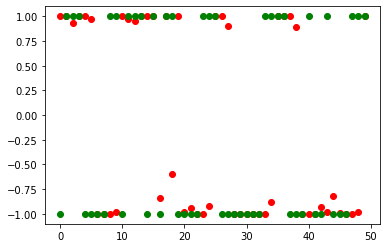

In [15]:
# LSTM
mdlBiLSTM = Sequential(name="BiLSTM_EQUALIZER")

forwardLayer = LSTM(1,
                    activation="tanh",
                    recurrent_activation="tanh",
                    #return_sequences=False,
                    )

backwardLayer = LSTM(1,
                    activation="tanh",
                    recurrent_activation="tanh",
                    #return_sequences=False,
                    go_backwards=True
                    )

mdlBiLSTM.add(Bidirectional(forwardLayer,
                            backward_layer=backwardLayer,
                            input_shape=(cLen, 1),
                            ),
                            )

lossBiLSTM = keras.losses.MeanAbsoluteError()
optBiLSTM = keras.optimizers.Adam(learning_rate=0.1)

mdlBiLSTM.compile(loss=lossBiLSTM,
                  optimizer=optBiLSTM,
                  metrics=['accuracy'],
                  )

print("\nSUMMARY:")
mdlBiLSTM.summary()

historyBiLstm = mdlBiLSTM.fit(XTrain, YTrain, 
                              epochs=10,
                              validation_data=(XTest, YTest),
                              verbose=0,
                              )
# Plot loss
plt.plot(historyBiLstm.history['loss'], c='r')
plt.plot(historyBiLstm.history['val_loss'], c='g')
plt.grid()
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predict
yPredBiLSTM = mdlBiLSTM.predict(XTest)
linkReport(yPredBiLSTM[:,0], YTest, demodulator)

# Plot 
len = 50 #_y_test.shape[0]
plt.scatter(range(len), yPredBiLSTM[0:len, 0].reshape(len), c='r')
plt.scatter(range(len), YTest[0:len].reshape(len), c='g')

### MLP


SUMMARY:
Model: "MLP_EQUALIZER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 12)                72        
                                                                 
 dense_90 (Dense)            (None, 1)                 13        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


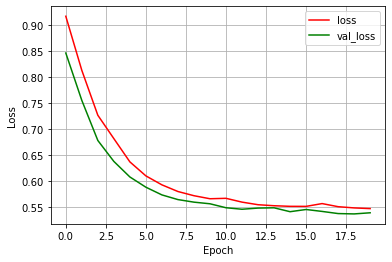

Link Report (BPSK):
    SER, 2.6357947434292863e-1, (1053/3995)
    BER, 2.6357947434292863e-1, (1053/3995)
    EVM, 102.1102248950089 [RMS]

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.73      0.73      0.73      1985
         1.0       0.74      0.74      0.74      2010

    accuracy                           0.74      3995
   macro avg       0.74      0.74      0.74      3995
weighted avg       0.74      0.74      0.74      3995



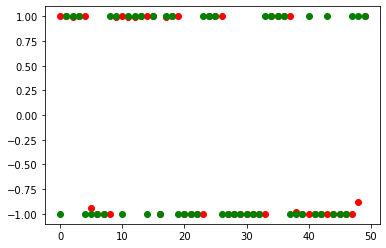

In [43]:
mdlMLP = Sequential(name="MLP_EQUALIZER")
mdlMLP.add(Dense(12, input_dim=cLen, activation='tanh'))
#mdlMLP.add(Dense(4, activation='tanh'))
mdlMLP.add(Dense(1, activation='tanh'))

lossMLP = keras.losses.MeanAbsoluteError()
optMLP = keras.optimizers.Adam(learning_rate=0.01)
metricMLP = keras.metrics.Accuracy()

mdlMLP.compile(loss=lossMLP,
               optimizer=optMLP,
               metrics=metricMLP)

print("\nSUMMARY:")
mdlMLP.summary()

historyMLP = mdlMLP.fit(xTrain, yTrain,
                        epochs=20,
                        #batch_size=1000,
                        validation_data=(xTest, yTest),
                        verbose=0,
                        )
# Plot loss
plt.plot(historyMLP.history['loss'], c='r')
plt.plot(historyMLP.history['val_loss'], c='g')
plt.grid()
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predict from model
yPredMLP = mdlMLP.predict(xTest)
linkReport(yPredMLP, yTest, demodulator)
yPredEstMLP = demodulator.estimateSymbols(yPredMLP)
print('\nClassification Report:')
print(classification_report(yTest, yPredEstMLP))

# Plot 
len = 50 #_y_test.shape[0]
plt.scatter(range(len), yPredMLP[0:len].reshape(len), c='r')
plt.scatter(range(len), yTest[0:len].reshape(len), c='g')